In [2]:
"""
OBJETIVO : Realizar el QC de SENAMHI en los datos, con la finalidad de
           identificar los datos erroneos, conformes y dudosos correctamente.
"""
Autor='Diego Paredes'

In [3]:
# Graficos y visualizaciones
import matplotlib.pyplot as plt

# Liberias para manejo de datos
import pandas as pd
import numpy as np

# Liberias estandar
import time
import os

In [4]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [5]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 
imagenTest = 'D:/GOES/C13/2020/03/G16_C13_Cyl_20200320-2000.nc'
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'

#Variables generales
products = ['C07','C08','C13']

#!El '00' debe ir al final!
times = ['10','20','30','40','50','00']

In [6]:
# Solo se usa una vez, para cambiar el nombre de los archivos 
# Coloca como nuevo nombre el codigo de la estacion, para facilitar su uso
def changeUmbralesFileName(DUmbrales):
    FUmbrales = os.listdir(DUmbrales)
    start_time = time.time()
    errors = []
    for umbName in FUmbrales:
        tempUmb = pd.read_csv(f'{DUmbrales}/{umbName}', nrows=5, sep=';')
        try:
            os.rename(f'{DUmbrales}/{umbName}', f'{DUmbrales}/UMBRAL-{tempUmb["IDESTACION"][0]}.csv')
        except:
            errors.append(tempUmb)
    
    print(f'Cantidad de archivos procesados:       {len(FUmbrales)}')
    print(f'Archivos que no se pudieron renombrar: {len(errors)}')
    print(f"Tiempo tomado en renombrar:             %.5fs" % (time.time() - start_time))
    return errors
    

In [7]:
"""
Clasificacion V2
 - NC
 - ND
 - M01
 - D01
 - D02
 - C01 
"""
# Devuelve el nuevo flag V2 de una fila X
def getFlagV2(x, umbrales):
    dato = x['PRECIPITACION']
    
    # No existe dato
    if pd.isna(dato):
        return 'ND'
    
    # Test DUROS
    elif dato<0 or dato>=401:
        return 'M01'
    
    codigo = str(x['CODIGO'])
    mes =  int(x['FECHA'].split('/')[1]) -1
    hora = int(x['HORA'].split(':')[0])
    
    if not codigo in list(umbrales.keys()):
        val1 = -1
        val2 = -1
    else:
        val1 = umbrales[codigo][mes][hora][0]
        val2 = umbrales[codigo][mes][hora][1]
    
    # No existe umbrales
    if (val1==-1) and (val2==-1):
        return 'NC'
    
    
    # Umbral 2
    if dato > val2:
        return 'D02'
    
    # Umbral 1
    if dato > val1:
        return 'D01'       
    
    # Conforme    
    return 'C01'
    

In [8]:
# Genera el FlagV2 para todo una lista de archivos de DataFrame (listDS)
def applyFlagV2(listDS, umbrales):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listDS:
        try:
            df.append(pd.read_csv(name,encoding='latin-1'))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>1:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomadoen leer los archivos: %.2fs" % (time.time() - start_time))
    
    
    
    dsCompleto['FLAGV2'] = dsCompleto.apply(lambda x: getFlagV2(x, umbrales),axis=1)
    
    print("Tiempo tomado en procesar el dataset: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    
    return dsCompleto
    

In [9]:
# Reune todos los umbrales de los diferentes archivos en un solo diccionario
# Devuelve el diccionario, la lista con estaciones sin umbral y los errores
def getUmbralesResumen(DUmbrales,verb=20):
    umbrales = {}
    errors = []
    noMayor = []
    FUmbrales = os.listdir(DUmbrales)
    completos = 0
    
    start_time = time.time()
    print(f'Se procesaran  {len(FUmbrales)} archivos ...')    
    for files in FUmbrales:
        if not completos % verb:
            print("Progreso: %.2f %s en %.2fs"%(completos/len(FUmbrales)*100, '%',time.time() - start_time))
            
        dfUmb = pd.read_csv(f'{DUmbrales}/{files}', sep=';')
        codigo = str(dfUmb["IDESTACION"][0])
        umbrales[codigo] = [[[-1,-1] for j in range(24)] for e in range(12)]
        
        n = 0
        months = {0:'ENERO',1:'FEBRERO',2:'MARZO',3:'ABRIL',4:'MAYO',5:'JUNIO',6:'JULIO',
                  7:'AGOSTO',8:'SETIEMBRE',9:'OCTUBRE',10:'NOVIEMBRE',11:'DICIEMBRE'}
        for i in dfUmb.index:
            month = months[int(n/24)]
            hour = f'{int(n%24)}:00:00'              
            if month==dfUmb['DETALLEPERIODO'][i] and hour == dfUmb['DETHORA'][i]:
                umbrales[codigo][int(n/24)][int(n%24)][0] = dfUmb['VALORMAXIMO1'][i]
                umbrales[codigo][int(n/24)][int(n%24)][1] = dfUmb['VALORMAXIMO2'][i]
                
                # Verificamos que el umbral 2 sea mayor al 1
                if dfUmb['VALORMAXIMO2'][i] < dfUmb['VALORMAXIMO1'][i]:
                    noMayor.append(f'{codigo}-{i}')
            else:
                errors.append(f'{codigo}-{i}')
                
            n=n+1
        completos = completos + 1
        
    print("Tiempo total tomado: %.2fs" % (time.time() - start_time))
    print(f'Umbrales con valmax1 mayor a valmax2:  {len(noMayor)}')    
    print(f'Umbrales que no se encontraron:        {len(errors)}')        
    return umbrales, noMayor, errors        

In [10]:
# Nombre de los archivos a usar
Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'
DUmbrales = f'{path_base}/Archivos/Inicial/UMBRALES/'

In [11]:
%%time
# Resume de los flags por estacion
dfUmbrales = {'Codigo':[],'Umbral1':[], 'Umbral2':[], 'min1' :[], 'min2':[]}
FUmbrales = os.listdir(DUmbrales)
for fileU in FUmbrales:
    tempUmb = pd.read_csv(f'{DUmbrales}{fileU}',sep=';')
    dfUmbrales['Codigo'].append(tempUmb['IDESTACION'][0])
    dfUmbrales['min1'].append(tempUmb['VALORMINIMO1'].max())
    dfUmbrales['min2'].append(tempUmb['VALORMINIMO2'].max())  
    dfUmbrales['Umbral1'].append(tempUmb['VALORMAXIMO1'].max())
    dfUmbrales['Umbral2'].append(tempUmb['VALORMAXIMO2'].max())  
    
dfUmbrales = pd.DataFrame(dfUmbrales)
dfUmbrales.to_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_umbrales.csv',index=False)
dfUmbrales

CPU times: total: 828 ms
Wall time: 1.87 s


,Codigo,Umbral1,Umbral2,min1,min2
0,107131,8.9,17.9,0,0
1,109091,3.6,8.3,0,0
2,109093,3.7,21.2,0,0
3,109096,0.4,0.5,0,0
4,110137,2.2,4.6,0,0
...,...,...,...,...,...
214,47E880E2,4.2,24.0,0,0
215,47E89394,2.2,37.5,0,0
216,47E8B578,1.8,4.7,0,0
217,47E9177A,2.2,11.2,0,0


In [12]:
dfUmbrales

,Codigo,Umbral1,Umbral2,min1,min2
0,107131,8.9,17.9,0,0
1,109091,3.6,8.3,0,0
2,109093,3.7,21.2,0,0
3,109096,0.4,0.5,0,0
4,110137,2.2,4.6,0,0
...,...,...,...,...,...
214,47E880E2,4.2,24.0,0,0
215,47E89394,2.2,37.5,0,0
216,47E8B578,1.8,4.7,0,0
217,47E9177A,2.2,11.2,0,0


In [13]:
dfUmbrales['Umbral2'].min()

0.0

In [11]:
#dfUmbrales
dfEstaciones = pd.read_csv(Festaciones, index_col=1)
dfEstaciones.head(2)

,Unnamed: 0,ESTACION,LON,LAT,ALT
CODE,,,,,
X47E0D438,0,ALAMOR,-80.39788,-4.48047,116.0
X47E09732,1,LA ARDILLA,-80.39014,-4.48956,116.0


In [12]:
dfUmbrales['CODE'] = 'X' + dfUmbrales['Codigo'].astype(str)
dfUmbrales.set_index('CODE', inplace=True)
dfUmbrales.head(2)

,Codigo,Umbral1,Umbral2,min1,min2
CODE,,,,,
X107131,107131,8.9,17.9,0,0
X109091,109091,3.6,8.3,0,0


In [13]:

_dfJoined = pd.concat([dfEstaciones, dfUmbrales], axis=1)
_dfJoined.to_csv(f'{path_base}/Archivos/Reportes/Datos/stations_data.csv')
_dfJoined.head(2)

,Unnamed: 0,ESTACION,LON,LAT,ALT,Codigo,Umbral1,Umbral2,min1,min2
CODE,,,,,,,,,,
X47E0D438,0.0,ALAMOR,-80.39788,-4.48047,116.0,47E0D438,9.3,10.2,0.0,0.0
X47E09732,1.0,LA ARDILLA,-80.39014,-4.48956,116.0,47E09732,3.1,16.9,0.0,0.0


In [22]:
def plotMapPrecip(df2, tipo='TP'):   
    """
    Graficamos
    """
    #_df =df2[df2[tipo]==1]
    fig = px.scatter_mapbox(df2, lat="LAT", lon="LON", hover_data=['ESTACION'],                            
                            color = 'Umbral2',
                            #size='Umbral1',
                            zoom=5, height=800)
    
    
    fig.update_layout(
    mapbox_style="open-street-map")
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

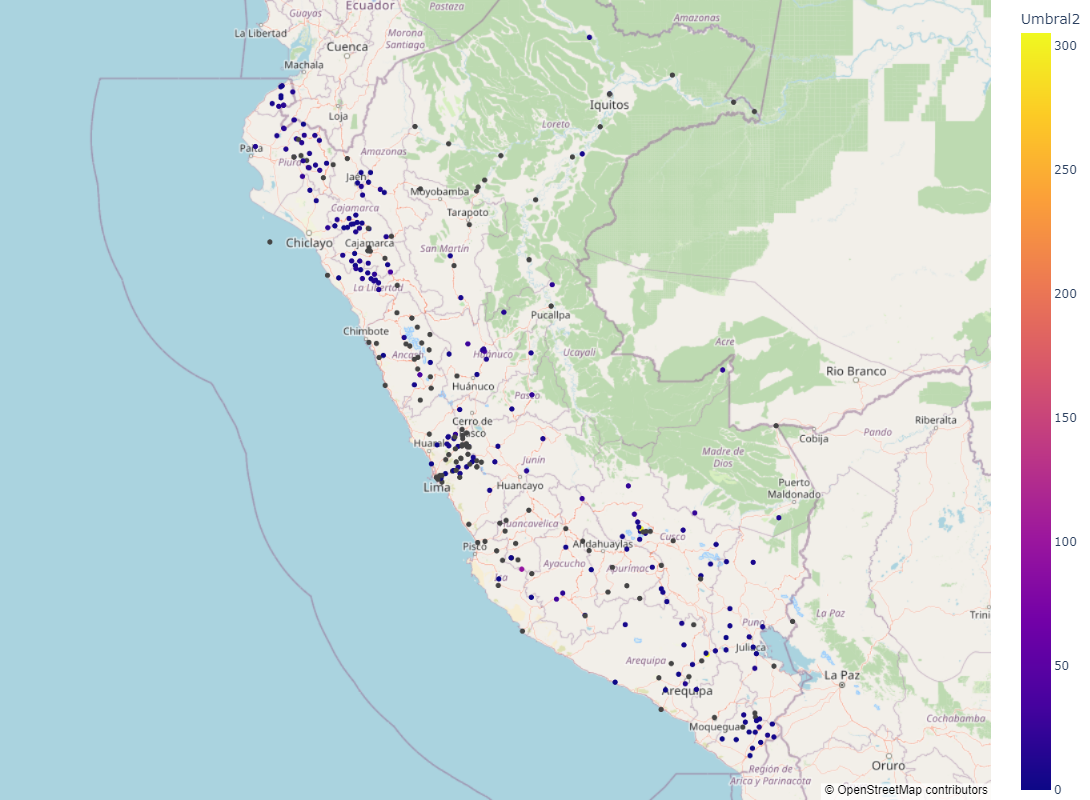

In [23]:
import plotly.express as px
plotMapPrecip(_dfJoined, tipo='')

In [47]:
a = 0.0008
print(f'{a:.2f}%')

0.00%


In [43]:
_dfJoined['difLon'] = abs(_dfJoined['LON'] - -80.397)
_dfJoined['difLat'] = abs(_dfJoined['LAT'] - -4.48047)
_dfJoined['dif'] = _dfJoined['difLon'] + _dfJoined['difLat']

In [44]:
_dfJoined.sort_values('dif', ascending=True).iloc[0]

Unnamed: 0         0.0
ESTACION        ALAMOR
LON          -80.39788
LAT           -4.48047
ALT              116.0
Codigo        47E0D438
Umbral1            9.3
Umbral2           10.2
min1               0.0
min2               0.0
difLon         0.00088
difLat             0.0
dif            0.00088
Name: X47E0D438, dtype: object

In [41]:
_temp = _dfJoined[(abs(_dfJoined['LON'] - -80.397)< 0.01) & ((_dfJoined['LAT'] - -4.48047)<0.01)]
_temp.iloc[0]

Unnamed: 0         0.0
ESTACION        ALAMOR
LON          -80.39788
LAT           -4.48047
ALT              116.0
Codigo        47E0D438
Umbral1            9.3
Umbral2           10.2
min1               0.0
min2               0.0
Name: X47E0D438, dtype: object

74.5 0.0


<AxesSubplot:>

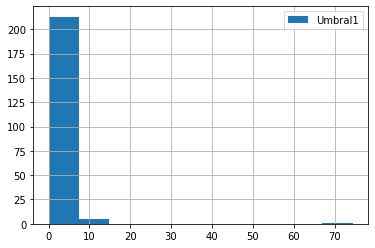

In [11]:
# Estadisticas del FLAGV2
print(dfUmbrales['Umbral1'].max(),dfUmbrales['Umbral1'].min())
dfUmbrales['Umbral1'].hist(legend=True)

305.5 0.0


<AxesSubplot:>

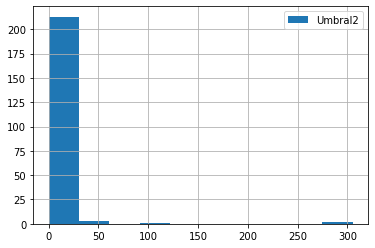

In [12]:
print(dfUmbrales['Umbral2'].max(),dfUmbrales['Umbral2'].min())
dfUmbrales['Umbral2'].hist(legend=True)

In [1]:
#errorsUmbrales = changeUmbralesFileName(DUmbrales)
umbrales, noMayor, errors = getUmbralesResumen(DUmbrales,verb=70)

NameError: name 'getUmbralesResumen' is not defined

In [14]:
# Realizamos el QC para hallar el flagV2
dsCompleto = applyFlagV2([Fdatos2021,Fdatos2020], umbrales)
dsCompleto.to_csv(f'{path_base}/Archivos/Dataset/dsFLAGV2.csv')

Se leera los archivos de datasets...
Tiempo tomadoen leer los archivos: 1.91s
Tiempo tomado en procesar el dataset: 60.38s
+Cantidad de datos leidos 3485658


In [14]:
# Visualizamos
dsCompleto =pd.read_csv(f'{path_base}/Archivos/Dataset/dsFLAGV2.csv')
dsCompleto.head(5)

,Unnamed: 0,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG,FLAGV2
0,0,4722A338,ACJANACO,01/01/2021,00:00:00,0.1,C0000001,C01
1,1,4722A338,ACJANACO,01/01/2021,01:00:00,0.0,C0000001,C01
2,2,4722A338,ACJANACO,01/01/2021,02:00:00,0.0,C0000001,C01
3,3,4722A338,ACJANACO,01/01/2021,03:00:00,0.0,C0000001,C01
4,4,4722A338,ACJANACO,01/01/2021,04:00:00,0.0,C0000001,C01


In [17]:
dsCompleto[dsCompleto['CODIGO']=='4722A338']

,Unnamed: 0,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG,FLAGV2
0,0,4722A338,ACJANACO,01/01/2021,00:00:00,0.1,C0000001,C01
1,1,4722A338,ACJANACO,01/01/2021,01:00:00,0.0,C0000001,C01
2,2,4722A338,ACJANACO,01/01/2021,02:00:00,0.0,C0000001,C01
3,3,4722A338,ACJANACO,01/01/2021,03:00:00,0.0,C0000001,C01
4,4,4722A338,ACJANACO,01/01/2021,04:00:00,0.0,C0000001,C01
...,...,...,...,...,...,...,...,...
2132449,2132449,4722A338,ACJANACO,31/12/2020,19:00:00,0.0,C0000001,C01
2132450,2132450,4722A338,ACJANACO,31/12/2020,20:00:00,0.0,C0000001,C01
2132451,2132451,4722A338,ACJANACO,31/12/2020,21:00:00,0.0,C0000001,C01
2132452,2132452,4722A338,ACJANACO,31/12/2020,22:00:00,0.0,C0000001,C01


In [ ]:
df_pruebas = pd.read_csv('')